In [3]:
import torch
torch.__version__

'1.13.1+cpu'

In [5]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     ---------------------------------------- 4.8/4.8 MB 7.9 MB/s eta 0:00:00
     ---------------------------------------- 2.3/2.3 MB 8.1 MB/s eta 0:00:00


In [6]:
torch.cuda.is_available() # should be True, there is  issues with this one on StackOverFlow, but it doesn't affect the result

False

In [16]:
import torchvision
import numpy as np
import torchvision.transforms as transforms

In [8]:
train_set = torchvision.datasets.FashionMNIST(
root = './data',
train = True,
download = True,
transform = transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [9]:
len(train_set)

60000

In [10]:
def show_img(img, label):
    print('Label: ', label)
    plt.imshow(img.permute(1,2,0), cmap = 'gray')

In [11]:
import matplotlib.pyplot as plt

In [12]:
img, label = train_set[0]
img.shape, label

(torch.Size([1, 28, 28]), 9)

Label:  5


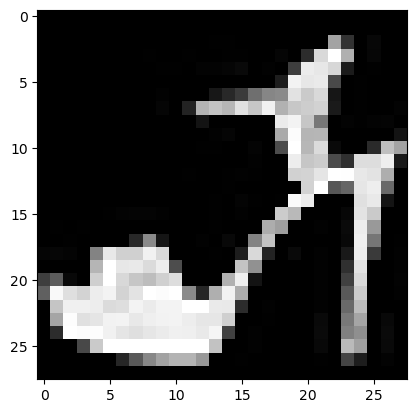

In [15]:
show_img(*train_set[9])

In [17]:
def split_indices(n, val_per, seed = 0):
    # this will create (n*val_per) integers
    n_val = int(n * val_per)
    # It is of utmost importance to create Reproducible data to into train & Validation set
    np.random.seed(seed)
    # This will create n mutually exclusive n index, in range 0 to 59999
    idx = np.random.permutation(n)
    # First n_val, will be validation and rest will be Train
    return idx[n_val : ], idx[: n_val]

In [18]:
val_per = 0.2
rand_seed = 42

train_indices, val_indices = split_indices(len(train_set), val_per, rand_seed)

print(len(train_indices), len(val_indices))

48000 12000


In [19]:
print("Validation Indices: ", val_indices[:20])
print("Training Indices: ", train_indices[:20])

Validation Indices:  [12628 37730 39991  8525  8279 51012 14871 15127  9366 33322 53390 21819
  5026 23428 45297 26354 30195 47038 20731 34047]
Training Indices:  [48572 38696 13611 35213 31766 57477  9165 21399 44113 55436 33761  2417
 10339 21794 59625 38542 10557  4120 46651 59905]


In [20]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [21]:
batch_size = 512

train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(train_set, batch_size, sampler = train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(train_set, batch_size, sampler = val_sampler)

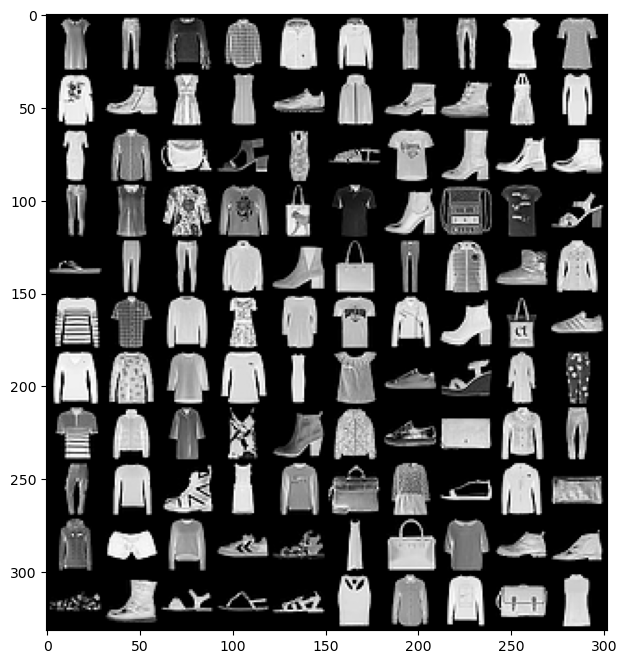

In [22]:
from torchvision.utils import make_grid

def show_batch(dl):
    for img, label in dl:
        fig, ax = plt.subplots(figsize = (12,8))
        ax.imshow(make_grid(img[:110], 10).permute(1,2,0))
        break
        
show_batch(val_dl)

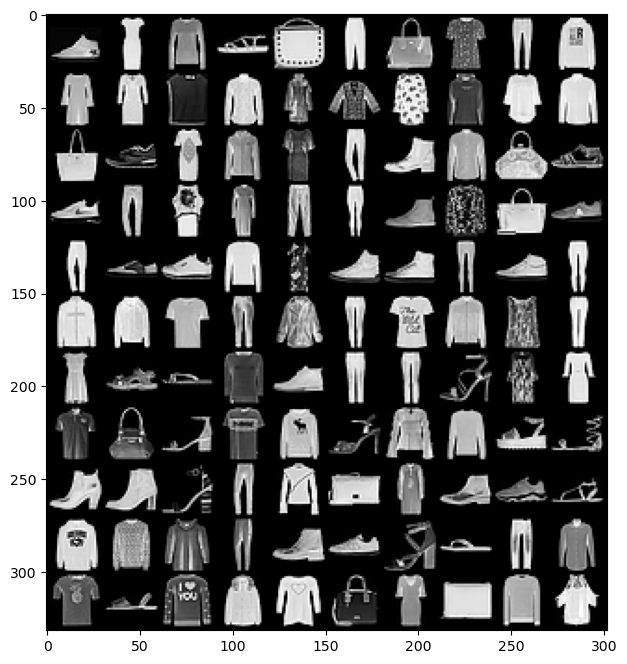

In [23]:
show_batch(train_dl)

In [24]:
import torch.nn as nn
import torch.nn.functional as F

In [25]:
model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # Output size: bs * 8 *14*14
    
    nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), #Output Size: bs * 16 * 7 * 7
    
    nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), #Output Size: bs * 32 * 3 * 3
    
    nn.Flatten(),
    nn.Linear(32 * 3 * 3, 64),
    nn.Linear(64, 10))

In [26]:
sample = next(iter(train_set))
img = sample[0]
img.shape

torch.Size([1, 28, 28])

In [27]:
img.unsqueeze(1).shape

torch.Size([1, 1, 28, 28])

In [28]:
out = model(img.unsqueeze(0))
out

tensor([[-0.0322, -0.0053,  0.0542,  0.0775,  0.0658, -0.0378, -0.1223,  0.0311,
         -0.0607, -0.0710]], grad_fn=<AddmmBackward0>)

In [29]:
F.softmax(out)

C:\Users\nsoyf\AppData\Local\Temp\ipykernel_11252\1665879703.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(out)


tensor([[0.0976, 0.1003, 0.1064, 0.1089, 0.1077, 0.0971, 0.0892, 0.1040, 0.0949,
         0.0939]], grad_fn=<SoftmaxBackward0>)

In [30]:
for images, labels in train_dl:
    print('Image Shape', images.shape)
    out = model(images)
    print('output shape', out.shape)
    print('out[0]', out[0])
    break
    
probs = F.softmax(out[0], dim = 0)
probs

m = torch.argmax(probs)
m

Image Shape torch.Size([512, 1, 28, 28])
output shape torch.Size([512, 10])
out[0] tensor([-0.0221, -0.0078,  0.0464,  0.0905,  0.0603, -0.0301, -0.1146,  0.0217,
        -0.0514, -0.0702], grad_fn=<SelectBackward0>)


tensor(3)

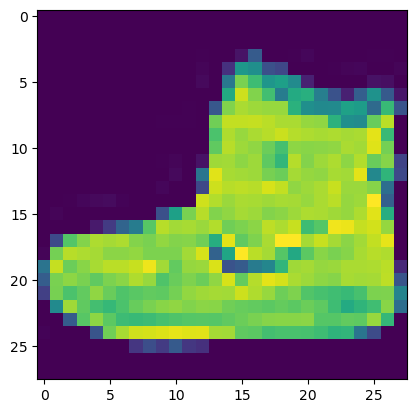

In [31]:
plt.imshow(img.permute(1,2,0))


In [32]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [33]:
device = get_default_device()
device

device(type='cpu')

In [34]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=288, out_features=64, bias=True)
  (11): Linear(in_features=64, out_features=10, bias=True)
)

In [35]:
def loss_batch(model, loss_func, x, y, opt = None, metric = None):
    
    pred = model(x)
    
    loss = loss_func(pred, y)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    metric_result = None
    
    if metric is not None:
        metric_result = metric(pred, y)
        
    return loss.item(), len(x), metric_result

In [36]:
def evaluate(model, loss_fn, val_dl, metric = None):
    
    with torch.no_grad():
        
        results = [loss_batch(model, loss_fn, x, y, metric = metric) for x, y in val_dl]
        
        losses, nums, metrics = zip(*results)
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
            
    return avg_loss, total, avg_metric

In [41]:
def fit(epochs, model, loss_fn, train_dl, val_dl, opt_fn = None, lr = None, metric = None):
    
    train_losses, val_losses, val_metrics = [], [], []
    history = []
    
    if opt_fn is None: opt_fn = torch.optim.Adam
        
    opt = opt_fn(model.parameters(), lr = lr)
    
    for epoch in range(epochs):
        
        model.train()
        for x, y in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, x, y, opt)
            
        model.eval()
        result = evaluate(model, loss_fn, val_dl, metric)
        val_loss, total, val_metric = result
        history.append(result)
        
        train_losses.append(train_loss)
        val_losses.append(val_losses)
        val_metrics.append(val_metric)
        
        if metric is None:
            print('Epoch{}/{}, train_loss: {:.4f}, val_loss: {:.4f}' 
                 .format(epoch+1, epochs, train_loss, val_loss))
            
        else:
            print('Epoch {}/{}, train_loss: {:.4f}, val_loss: {:.4f}, val_{}: {:.4f}'
                 .format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric))
            
    return train_losses, val_losses, val_metrics

In [42]:
# Define accuracy as measure of perfomance
def accuracy(output, labels):
    _, preds = torch.max(output, dim = 1)
    
    return torch.sum(preds == labels).item() / len(preds)

In [43]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, val_dl, metric = accuracy)

print(val_loss, val_acc)

2.3054301795959473 0.09866666666666667


In [45]:
num_epochs = 50
opt_fn = torch.optim.Adam
lr = 1e-4
history = []
history += fit(num_epochs, model, F.cross_entropy, train_dl, val_dl, opt_fn, lr, accuracy)

Epoch 1/50, train_loss: 2.2137, val_loss: 2.2158, val_accuracy: 0.3441
Epoch 2/50, train_loss: 1.3807, val_loss: 1.3770, val_accuracy: 0.5622
Epoch 3/50, train_loss: 0.9627, val_loss: 0.9435, val_accuracy: 0.6617
Epoch 4/50, train_loss: 0.7870, val_loss: 0.8402, val_accuracy: 0.6994
Epoch 5/50, train_loss: 0.8269, val_loss: 0.7818, val_accuracy: 0.7145
Epoch 6/50, train_loss: 0.7306, val_loss: 0.7477, val_accuracy: 0.7267
Epoch 7/50, train_loss: 0.7429, val_loss: 0.7219, val_accuracy: 0.7357
Epoch 8/50, train_loss: 0.6548, val_loss: 0.7010, val_accuracy: 0.7422
Epoch 9/50, train_loss: 0.6987, val_loss: 0.6830, val_accuracy: 0.7475
Epoch 10/50, train_loss: 0.6154, val_loss: 0.6677, val_accuracy: 0.7532
Epoch 11/50, train_loss: 0.6569, val_loss: 0.6616, val_accuracy: 0.7499
Epoch 12/50, train_loss: 0.6225, val_loss: 0.6406, val_accuracy: 0.7634
Epoch 13/50, train_loss: 0.6662, val_loss: 0.6299, val_accuracy: 0.7680
Epoch 14/50, train_loss: 0.6770, val_loss: 0.6163, val_accuracy: 0.7713
E

In [46]:
test_set = torchvision.datasets.FashionMNIST(
root = './data',
train = False,
download = True,
transform = transforms.Compose([transforms.ToTensor()]))

In [47]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 9 , Predicted: 9


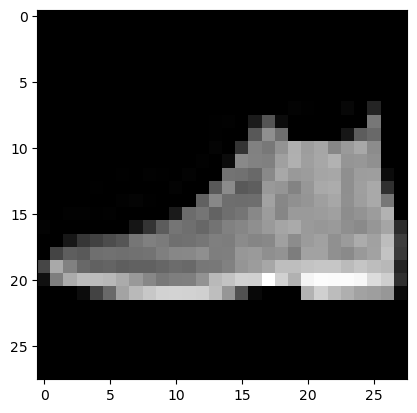

In [48]:
img, label = test_set[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


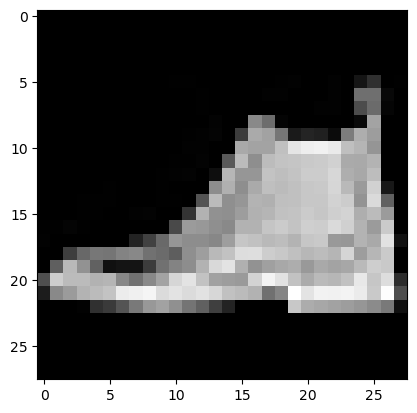

In [49]:
img, label = test_set[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 6 , Predicted: 6


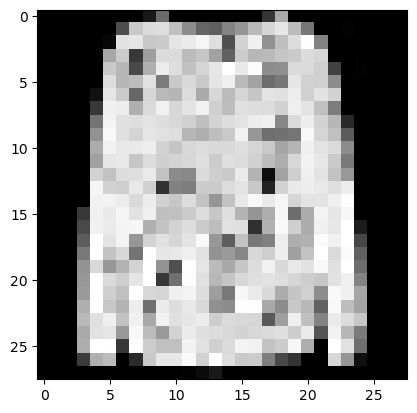

In [50]:
img, label = test_set[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [51]:
test_loader = DeviceDataLoader(DataLoader(test_set, batch_size=256), device)
result = evaluate(model, F.cross_entropy, test_loader, metric = accuracy)
result
Accuracy = result[2] * 100
Accuracy
loss = result[0]
print("Total Losses: {}, Accuracy: {}".format(loss, Accuracy))

Total Losses: 0.449250097322464, Accuracy: 84.0
